# Astronomy 8824 - Numerical and Statistical Methods in Astrophysics

## Numerical Methods Topic IV. FFTs and their Applications

These notes are for the course Astronomy 8824: Numerical and Statistical Methods in Astrophysics. It is based on notes from David Weinberg with modifications and additions by Paul Martini.
David's original notes are available from his website: http://www.astronomy.ohio-state.edu/~dhw/A8824/index.html

#### Background reading: 
- Numerical Recipes Chapers 12 and 13, especially $\S\S 12.0-12.2, 13.0-13.2$
- Statistics, Data Mining, and Machine Learning in Astronomy, Chapter 10
- _The Fourier Transform And Its Applications_ by Ronald Bracewell

In [1]:
import math
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
from astropy.convolution import Gaussian1DKernel, convolve

# matplotlib settings 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title

In [2]:
! pip install pyfftw --user
import pyfftw

LaTex macros hidden here -- 
$\newcommand{\expect}[1]{{\left\langle #1 \right\rangle}}$
$\newcommand{\intinf}{\int_{-\infty}^{\infty}}$
$\newcommand{\xbar}{\overline{x}}$
$\newcommand{\ybar}{\overline{y}}$
$\newcommand{\like}{{\cal L}}$
$\newcommand{\llike}{{\rm ln}{\cal L}}$
$\newcommand{\xhat}{\hat{x}}$
$\newcommand{\yhat}{\hat{y}}$
$\newcommand{\xhati}{\hat{x}_i}$
$\newcommand{\yhati}{\hat{y}_i}$
$\newcommand{\sigxi}{\sigma_{x,i}}$
$\newcommand{\sigyi}{\sigma_{y,i}}$
$\newcommand{\cij}{C_{ij}}$
$\newcommand{\cinvij}{C^{-1}_{ij}}$
$\newcommand{\cinvkl}{C^{-1}_{kl}}$
$\newcommand{\cinvmn}{C^{-1}_{mn}}$
$\newcommand{\valpha}{\vec \alpha}$
$\newcommand{\vth}{\vec \theta}$
$\newcommand{\ymod}{y_{\rm mod}}$
$\newcommand{\dy}{\Delta y}$
$\newcommand{tphi}{\widetilde{\phi}}$
$\newcommand{\trho}{\widetilde{\rho}}$


### Introduction and Motivation

Fourier Transforms are typically applied to two classes of problems: 1) As a useful computational tool, e.g. for N-body calculations; 2) As an analysis tool, e.g. to identify periodic signals. 

Physical descriptions are sometimes more natural in the Fourier domain, such as the distribution of density fluctuations, the characterization of turbulence, and the behaviour of variable objects.

Some mathematical operations are easier in the Fourier domain, or it may be possible to apply an approximate solution to modes of long or short wavelength. Examples are (de)convolution, correlation, optimal filtering, power spectrum analysis, computation of Fourier integrals, and solving some differential equations. 

Periodic signals are often interesting. Fourier Transforms can be an efficient way to look for them.

Some numerical operations can be done _much_ faster via Fast Fourier Transform if the number of data points $N$ is large.

For example, convolution is an operation $O(N^2)$ if done directly for two functions of length $N$.  (Sometimes the response function is much shorter than the function being convolved, in which case the scaling is only $O(N_{\rm data}N_{\rm response})$.)

But the FFT can be computed in $O(N \log_2 N)$ time, which may be orders-of-magnitude less.


### Definitions and Notation

I will mostly use the NR notation, but not always.

If $h(t)$ is a function of time, then its Fourier transform is
$$
H(f) = \int_{-\infty}^\infty h(t) e^{2\pi ift}dt.
$$
We can recover $h(t)$ from $H(f)$ by applying an inverse
Fourier transform,
$$
h(t) = \int_{-\infty}^\infty H(f) e^{-2\pi ift} df,
$$
i.e., just change the sign in the exponent. 

If $t$ is a time in sec, then $f$ is a frequency in sec$^{-1}$ (Hz).

It is useful to think of an FT as a linear operation on a function, and that $h(t)$ and $H(f)$ are two representations of the same function. 

Another common notation is to write the FT of $f(x)$ as
$$
\tilde{f}(k) = \int_{-\infty}^\infty f(x) e^{2\pi ikx}dx.
$$
This is common when $x$ is a unit of length, in which case 
the wavenumber $k$ has units of inverse length.

_Caution_: Other Fourier conventions are frequently used,
such as
$$
H(\omega) = \int_{-\infty}^\infty h(t) e^{i\omega t}dt, \qquad
h(t) = {1 \over 2\pi} \int_{-\infty}^\infty H(\omega) e^{-i\omega t}d\omega.
$$

The NR convention ($2\pi$ in the exponent) is standard for numerical
FTs, and it leaves you with less to remember.

However, you always have to check Fourier conventions when 
comparing to or using papers or books, and figuring out the
conversions can be a pain.

If you use Fourier transforms in a paper, make clear what convention
you are using.


### Decomposition and Identities

Recall that $e^{2\pi i ft} = \cos(2\pi ft) + i\sin(2\pi ft)$.

The FT relation expresses a decomposition of the function $h(t)$ into a sum (integral in the continuous case) of sinusoidal functions.

The sinusoidal basis is complete and orthogonal.  Any function can be decomposed this way, and different modes are independent, in that, for positive integers $m$, $n$:
$$\eqalign{
\int_{-\pi}^\pi \cos nx\cos mx dx &= \pi \delta_{mn}, \cr
\int_{-\pi}^\pi \sin nx\sin mx dx &= \pi \delta_{mn}, \cr
\int_{-\pi}^\pi \cos nx\sin mx dx &= 0.
}
$$

In general, a FT maps a complex function into another complex function.

If $h(t)$ is real, then
$$
H(f) = \int_{-\infty}^\infty \cos(2\pi ft) \,h(t) dt + 
       i \int_{-\infty}^\infty \sin(2\pi ft)\, h(t) dt
$$
is Hermitian, $H(f) = [H(-f)]^*$, because cosine is an even function and sine is an odd function. (Reminder: an even function is one where $f(t) = f(-t)$ and an odd function is one where $g(t) = -g(-t)$.)  

A Hermitian Matrix is a complex, square matrix that is equal to its own conjugate transform. That is: $a_{ij} = \bar{a_{ji}}$ or $A = \bar{A^T}$. They are the complex extension of real, symetric matrices, and both always have real eigenvalues. 

If $h(t)$ is real and symmetric about zero then $H(f)$ is real (see NR for other symmetries). Symmetries can be useful because in some cases they may be used to improve computational efficiency.


#### Other useful identities:

If $h(t)$ and $H(f)$ are an FT pair then
$$\eqalign{
h(at)~ \hbox{is a Fourier transform pair with}~ {1\over|a|} H(f/a) ~  \mathrm{- (this\,is\,time\,scaling)} \cr
\frac{1}{|b|} h(t/b) ~ \hbox{is a Fourier transform pair with}~ H(bf) ~ \mathrm{- (this\,is\,frequency\,scaling)}
}$$
If a function is narrow in the time domain, then its Fourier transform is broad in the frequency domain, and vice versa.

For example (a useful one), with our Fourier convention, the FT of a time-domain Gaussian $e^{-t^2/2\sigma_t^2}$ is a frequency-domain Gaussian $e^{-2\pi^2\sigma_t^2 f^2} = e^{-f^2/2\sigma_f^2}$ with $\sigma_f=1/(2\pi\sigma_t)$.

With the $H(\omega)$ convention, $\sigma_\omega=1/\sigma_t$.

A shift of origin in the time domain is equivalent to shifting the complex phase in the Fourier domain,
$$
h(t-t_0)~ \hbox{is a Fourier transform pair with}~ H(f)e^{2\pi i ft_0}.
$$

The FT is a linear operation, so the FT of a linear combination of functions is the linear combination of their FTs.

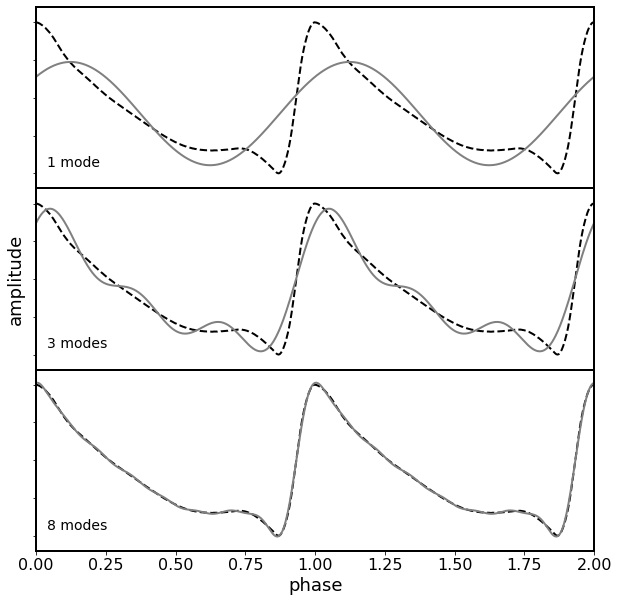

In [3]:
# https://www.astroml.org/book_figures/chapter10/fig_rrlyrae_reconstruct.html
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
#import numpy as np
#from matplotlib import pyplot as plt

from astroML.datasets import fetch_rrlyrae_templates

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#if "setup_text_plots" not in globals():
#    from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Load the RR Lyrae template
templates = fetch_rrlyrae_templates()
x, y = templates['115r'].T

#------------------------------------------------------------
# Plot the results
# fig = plt.figure(figsize=(5, 5))
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0)

kvals = [1, 3, 8]
subplots = [311, 312, 313]

for (k, subplot) in zip(kvals, subplots):
    ax = fig.add_subplot(subplot)

    # Use FFT to fit a truncated Fourier series
    y_fft = np.fft.fft(y)
    y_fft[k + 1:-k] = 0
    y_fit = np.fft.ifft(y_fft).real

    # plot the true value and the k-term reconstruction
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y, y]), '--k', lw=2)
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y_fit, y_fit]), color='gray')

    label = "%i mode" % k
    if k > 1:
        label += 's'

    ax.text(0.02, 0.1, label, ha='left', va='bottom',
            transform=ax.transAxes)

    if subplot == subplots[-1]:
        ax.set_xlabel('phase')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    if subplot == subplots[1]:
        ax.set_ylabel('amplitude')
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(0, 2)
    ax.set_ylim(1.1, -0.1)

plt.show()


### The Convolution Theorem

The convolution of two functions $g$ and $h$ is
$$
f(t) = g * h \equiv \int_{-\infty}^\infty g(\tau)h(t-\tau)d\tau.
$$

The FT of $g * h$ is $G(f) H(f)$, i.e., the Fourier transform of the convolution is the product of the Fourier transforms. 

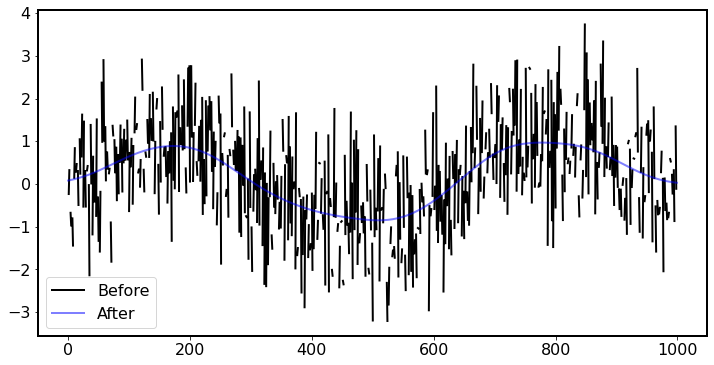

In [4]:
# Convolution Example from https://docs.astropy.org/en/stable/convolution/index.html

plt.figure(figsize=(12, 6))
#plt.figure(3).clf()

# Generate fake data
x = np.arange(1000).astype(float)
y = np.sin(x / 100.) + np.random.normal(0., 1., x.shape)
y[::3] = np.nan

# Create kernel object
g = Gaussian1DKernel(stddev=50)

# Convolve data
z = convolve(y, g)

# Plot data before and after convolution
plt.plot(x, y, 'k-', label='Before')
plt.plot(x, z, 'b-', label='After', alpha=0.5, linewidth=2)
plt.legend(loc='best')
plt.show()

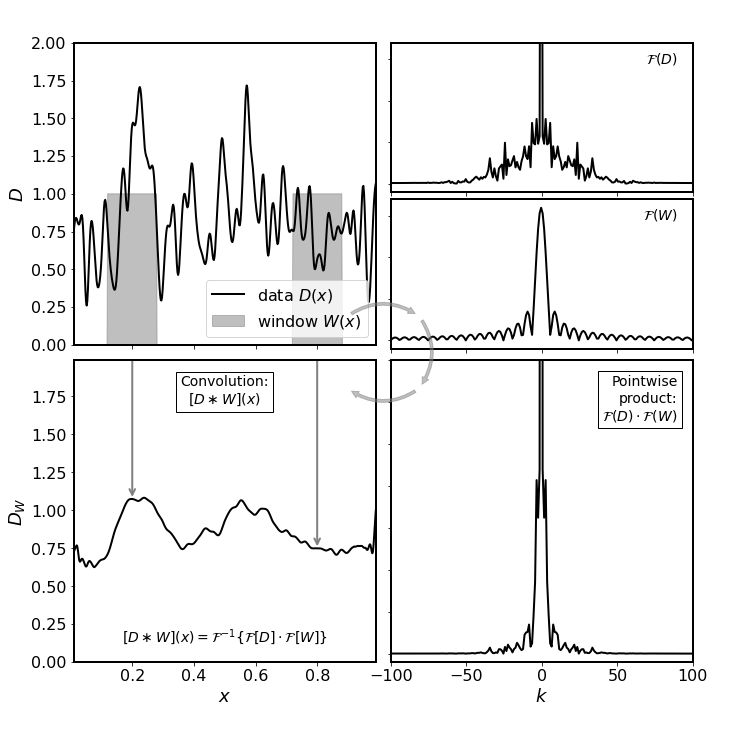

In [5]:
# https://www.astroml.org/book_figures/chapter10/fig_convolution_diagram.html
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
# import numpy as np
# from matplotlib import pyplot as plt

from scipy.signal import fftconvolve

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
# if "setup_text_plots" not in globals():
#     from astroML.plotting import setup_text_plots
# setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Generate random x, y with a given covariance length
np.random.seed(1)
x = np.linspace(0, 1, 500)
h = 0.01
C = np.exp(-0.5 * (x - x[:, None]) ** 2 / h ** 2)
y = 0.8 + 0.3 * np.random.multivariate_normal(np.zeros(len(x)), C)

#------------------------------------------------------------
# Define a normalized top-hat window function
w = np.zeros_like(x)
w[(x > 0.12) & (x < 0.28)] = 1

#------------------------------------------------------------
# Perform the convolution
y_norm = np.convolve(np.ones_like(y), w, mode='full')
valid_indices = (y_norm != 0)
y_norm = y_norm[valid_indices]

y_w = np.convolve(y, w, mode='full')[valid_indices] / y_norm

# trick: convolve with x-coordinate to find the center of the window at
#        each point.
x_w = np.convolve(x, w, mode='full')[valid_indices] / y_norm

#------------------------------------------------------------
# Compute the Fourier transforms of the signal and window
y_fft = np.fft.fft(y)
w_fft = np.fft.fft(w)

yw_fft = y_fft * w_fft
yw_final = np.fft.ifft(yw_fft)

#------------------------------------------------------------
# Set up the plots
# fig = plt.figure(figsize=(5, 5))
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0.09, bottom=0.09, right=0.95, top=0.95,
                    hspace=0.05, wspace=0.05)

#----------------------------------------
# plot the data and window function
ax = fig.add_subplot(221)
ax.plot(x, y, '-k', label=r'data $D(x)$')
ax.fill(x, w, color='gray', alpha=0.5,
        label=r'window $W(x)$')
ax.fill(x, w[::-1], color='gray', alpha=0.5)

ax.legend()
ax.xaxis.set_major_formatter(plt.NullFormatter())

ax.set_ylabel('$D$')

ax.set_xlim(0.01, 0.99)
ax.set_ylim(0, 2.0)

#----------------------------------------
# plot the convolution
ax = fig.add_subplot(223)
ax.plot(x_w, y_w, '-k')

ax.text(0.5, 0.95, "Convolution:\n" + r"$[D \ast W](x)$",
        ha='center', va='top', transform=ax.transAxes,
        bbox=dict(fc='w', ec='k'), zorder=2)

ax.text(0.5, 0.05,
        (r'$[D \ast W](x)$' +
         r'$= \mathcal{F}^{-1}\{\mathcal{F}[D] \cdot \mathcal{F}[W]\}$'),
        ha='center', va='bottom', transform=ax.transAxes)

for x_loc in (0.2, 0.8):
    y_loc = y_w[x_w <= x_loc][-1]
    ax.annotate('', (x_loc, y_loc), (x_loc, 2.0), zorder=1,
                arrowprops=dict(arrowstyle='->', color='gray', lw=2))

ax.set_xlabel('$x$')
ax.set_ylabel('$D_W$')

ax.set_xlim(0.01, 0.99)
ax.set_ylim(0, 1.99)

#----------------------------------------
# plot the Fourier transforms
N = len(x)
k = - 0.5 * N + np.arange(N) * 1. / N / (x[1] - x[0])

ax = fig.add_subplot(422)
ax.plot(k, abs(np.fft.fftshift(y_fft)), '-k')

ax.text(0.95, 0.95, r'$\mathcal{F}(D)$',
        ha='right', va='top', transform=ax.transAxes)

ax.set_xlim(-100, 100)
ax.set_ylim(-5, 85)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax = fig.add_subplot(424)
ax.plot(k, abs(np.fft.fftshift(w_fft)), '-k')

ax.text(0.95, 0.95,  r'$\mathcal{F}(W)$', ha='right', va='top',
        transform=ax.transAxes)

ax.set_xlim(-100, 100)
ax.set_ylim(-5, 85)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

#----------------------------------------
# plot the product of Fourier transforms
ax = fig.add_subplot(224)
ax.plot(k, abs(np.fft.fftshift(yw_fft)), '-k')

ax.text(0.95, 0.95, ('Pointwise\nproduct:\n' +
                     r'$\mathcal{F}(D) \cdot \mathcal{F}(W)$'),
        ha='right', va='top', transform=ax.transAxes,
        bbox=dict(fc='w', ec='k'), zorder=2)

ax.set_xlim(-100, 100)
ax.set_ylim(-100, 3500)

ax.set_xlabel('$k$')

ax.yaxis.set_major_formatter(plt.NullFormatter())

#------------------------------------------------------------
# Plot flow arrows
ax = fig.add_axes([0, 0, 1, 1], xticks=[], yticks=[], frameon=False)

arrowprops = dict(arrowstyle="simple",
                  color="gray", alpha=0.5,
                  shrinkA=5, shrinkB=5,
                  patchA=None,
                  patchB=None,
                  connectionstyle="arc3,rad=-0.35")

ax.annotate('', [0.57, 0.57], [0.47, 0.57],
            arrowprops=arrowprops,
            transform=ax.transAxes)
ax.annotate('', [0.57, 0.47], [0.57, 0.57],
            arrowprops=arrowprops,
            transform=ax.transAxes)
ax.annotate('', [0.47, 0.47], [0.57, 0.47],
            arrowprops=arrowprops,
            transform=ax.transAxes)

plt.show()

### The Correlation Theorem
The correlation of two functions $g$ and $h$ is
$$
\mathrm{Corr} (g,h) \equiv \int_{-\infty}^\infty g^*(t)h(t+\tau)dt
$$
where $g^*(t)$ is the complex conjugate of $g(t)$ and $\tau$ is often called the lag. 

The FT of Corr($g,h$) is $G^*(f)H(f)$. In other words, multiplying the FT of a function by the complex conjugate of the FT of the other function is equal to their correlation.

Reminder that the complex conjugate of a complex number is another complex number with the opposite sign on the imaginary component, e.g. the complex conjugate of $5 + 3i$ is $5 - 3i$. 

### Power Spectrum Density

The power spectrum density (PSD) of a time series defines the amount of power in a frequency interval $f \rightarrow f + df$. This is a measure of the importance of a given frequency interval (or mode). 
$$
PSD(f) = |H(f)|^2 + |H(-f)|^2
$$

For a sinuisoid with a single frequency, the PSD is one at that frequency and zero otherwise. 

The total power in a data set is the same regardless of whether this is computed in the frequency or the time domain:

$$
P_{tot} = \int^{\infty}_0 = \mathrm{PSD}(f) df = \int^{\infty}_{-\infty} |h(t)|^2 dt
$$
This is Parseval's theorem. 

### Nyquist frequency, aliasing

If a function is tabulated at discrete, evenly spaced locations with separation $\Delta$, then the highest frequency Fourier component that can be represented is one with critical frequency
$$
f_c = {1\over 2\Delta},
$$
known as the Nyquist frequency. For example, $\Delta$ could refer to discrete spatial or temporal samples of the signal.

A Nyquist frequency sine wave is sampled with two points per cycle.

If the function $h(t)$ is _bandwidth limited_, with the amplitude of all Fourier modes with $f > f_c$ equal to zero, then the sampled values at spacing $\Delta$ are enough to compute $h(t)$ exactly at any point using sinc interpolation (NR eq. 12.1.3).

$$
h(t) = \Delta \sum^{\infty}_{n=-\infty} h_n \frac{\sin [2 \pi f_c(t - n\Delta)]}{\pi (t - n\Delta) }
$$

This is a remarkable fact, and a useful one, e.g., for reconstructing a time series or shifting images to register
them _IF_ the PSF is fully sampled. This says that _all_ of the information content of a bandwidth-limited signal represented in this way. 

However, if it has power at $f>f_c$, then that power will spuriously contaminate Fourier modes with $f < f_c$.

This is known as aliasing.  

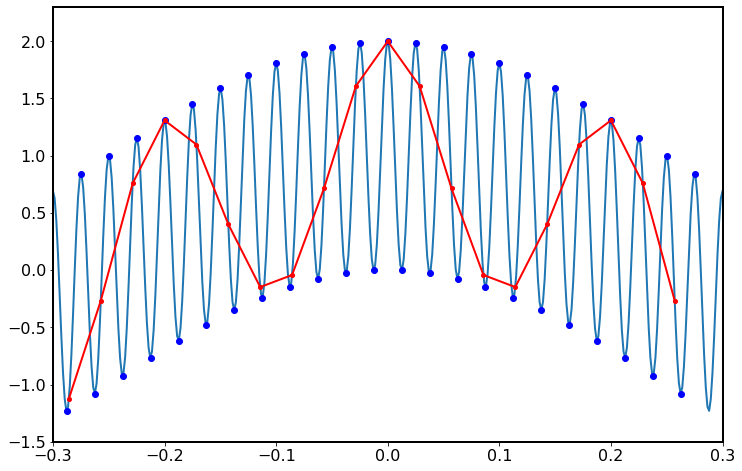

In [6]:
# https://glowingpython.blogspot.com/2011/09/sampling-theorem-explained-with-numpy.html

plt.figure(figsize=(12,8))
# sampling a signal badlimited to 40 Hz 
# with a sampling rate of 800 Hz
f = 40;  # Hz
tmin = -0.3
tmax = 0.3
t = np.linspace(tmin, tmax, 400)
x = np.cos(2*np.pi*t) + np.cos(2*np.pi*f*t) # signal sampling
plt.plot(t, x)

# sampling the signal with a sampling rate of 80 Hz
# in this case, we are using the Nyquist rate.
T = 1/80.0;
nmin = np.ceil(tmin / T)
nmax = np.floor(tmax / T)
n = np.arange(nmin,nmax)
x1 = np.cos(2*np.pi*n*T) + np.cos(2*np.pi*f*n*T)
plt.plot(n*T, x1, 'bo')

# sampling the signal with a sampling rate of 35 Hz
# note that 35 Hz is under the Nyquist rate.
T = 1/35.0;
nmin = np.ceil(tmin / T);
nmax = np.floor(tmax / T);
n = np.arange(nmin,nmax);
x2 = np.cos(2*np.pi*n*T) + np.cos(2*np.pi*f*n*T);
plt.plot(n*T, x2, '-r.',markersize=8)

plt.axis([-0.3, 0.3, -1.5, 2.3])
plt.show()

### One-Dimensional Fast Fourier Transform

Suppose that we have a function $h(t)$ tabulated on a grid of $N$ evenly spaced values.

An FFT is an efficient algorithm for computing the _discrete Fourier transform_, the sum
$$
H_n \equiv \sum_{k=0}^{N-1} h_k e^{2\pi i \, kn/N},
$$
for all values $n=-N/2$ to $N/2$.

In this notation, $k$ is indexing time or position values; $n$ represents frequency or wavenumber.

Naively, it looks like computing this for all $n$ should be an $O(N^2)$ operation, as there are $N$ values of $H_n$, and the evaluation of each $H_n$ requires a sum over $N$ values. 

The FFT uses the fact that a discrete Fourier transform of length $N$ can be written as a sum of two discrete Fourier transforms of length $N/2$.

This rule can be applied recursively to turn computing the Fourier transform into an $O(N\log_2 N)$ operation, which is vastly more efficient.

For example, for N = 1e6, this is the difference between:

In [7]:
N = 1e6
print("For N = {0:.0e}, this is the difference between {1:.0e} and {2:.0e} calculations".format(N, N*N, N*np.log2(N)))

N = 1e10
print("For N = {0:.0e}, this is the difference between {1:.0e} and {2:.0e} calculations".format(N, N*N, N*np.log2(N)))

For N = 1e+06, this is the difference between 1e+12 and 2e+07 calculations
For N = 1e+10, this is the difference between 1e+20 and 3e+11 calculations


In practice, instead of $n$ running from $-N/2$ to $N/2$, it runs from 0 to $N-1$.  The 0 value represents zero frequency $n=0$, the values $1 \leq n \leq N/2-1$ correspond to frequencies $0 < f < f_c$, the values $N/2+1 \leq n \leq N-1$ correspond to $-f_c < f < 0$, and the value $n=N/2$ corresponds to both $f=f_c$ and $f=-f_c$.  

Here $f_c = N/2$ is the critical or Nyquist frequency, the maximum frequency that can be represented by $N$ evenly spaced values of the function.

From the above equation, one can see that for $n=N/2$
$$
H_n = \sum h_k \left(e^{i\pi}\right)^k = \sum h_k (-1)^k 
    = \sum h_k \left(e^{-i\pi}\right)^k = H_{-n}.
$$

The discrete inverse Fourier transform is 
$$
h_k = {1 \over N} \sum_{n=0}^{N-1} H_ne^{-2\pi i \,kn/N}.
$$
A forward transform followed by an inverse transform returns the original data values $h_k$.

Some FFTs have a different normalization convention, so that there is no $1/N$ and a forward-then-inverse transform returns the original values multiplied by $N$. 

In general, be careful about normalization issues and about which order the data are stored in.  You will typically need to do some experimentation to make sure you have everything right.


### FFT Algorithm

There are many FFT algorithms, starting with work by Gauss in 1805! The most common implementation is by Cooley and Tukey, which recursively divides a discrete Fourier transform (DFT) of size $N = N_1 N_2$ into many smaller ones of sizes $N_1$ and $N_2$. 

Numerical recipes ($\S 12.2$) describes the algorithm of Danielson & Lanczos (1942). Here is a brief description of that derivation, although please see NR for more details. 

Danielson & Lanczos showed that a DFT of length $N$ could be written as the sum of two DFTs of length $N/2$, one composed of the even-numbered points, and the other of the odd-numbered points. 

The NR proof is (Eqn 12.2.3): 

$$ \eqalign{
F_k &= \sum^{N-1}_{j=0} e^{2 \pi i j k/N} f_j \cr
    &= \sum^{N/2 - 1}_{j=0} e^{2 \pi i k (2j)/N} f_{2j} + \sum^{N/2 - 1}_{j=0} e^{2\pi ik(2j+1)/N} f_{2j+1} \cr
    &= \sum^{N/2 - 1}_{j=0} e^{2 \pi i k j/(N/2)} f_{2j} + W^k \sum^{N/2 - 1}_{j=0} e^{2\pi ikj/(N/2)} f_{2j+1} \cr
    &= F^e_k + W^k F^o_k
}
$$
where $W^k \equiv e^{2 \pi i/N}$, $F^e_k$ is the $k$th component of the FT with length $N/2$ formed from the even components $f_j$, and $F^o_k$ is formed from the odd components. 

There are two key points here. First, note that each of the $k$ components is summed over $N/2$ components, rather than $N$. The second is that this idea may be used recursively, that is the $F^e_k$ and $F^o_k$ may each be reduced to the calculation of their $N/4$ even-numbered and odd-numbered datasets. For example, $F^e_k$ has $F^{ee}_k$ and $F^{eo}_k$.  If your original dataset is a power of 2, then you can keep splitting up the data until all of the transforms have length unity, e.g. $F^{ee}_k$ into $F^{eee}_k$ and $F^{eeo}_k$. (For DFTs, it is basically always a good idea to use arrays whose length are a power of two, even if you have to pad the arrays with zeros to increase them to this size.)

How does one relate the pattern of even and odd expressions to some input number $f_n$? There is a cool trick in bit reversal that solve this. If you reverse the pattern of $e$'s and $o$'s and assign $e=0$ and $o=1$, then the pattern will equal the binary representation of $n$.  

The FFT algorithm consequently has two parts. First, it prepares the data by sorting into bit-reversed order. Then the second part starts with an outer loop executed $\mathrm{log}_2 N$ times that calculates the transforms of length $2, 4, 8, ..., N$. Inside of this outer loop are two inner loops over the subtransforms and elements of each transform.  

### One-Dimensional Real-Valued FFT

An FFT transforms an array of complex numbers to another array of complex numbers.

If you want to Fourier transform an array of real numbers, you can just set the imaginary parts to zero before applying a regular FFT.

The outputs will be complex numbers, but they will satisfy the _Hermitian_ condition $H(f) = H^*(-f)$, so they still contain only $N$ pieces of information.

This strategy is fine if you are not strained for CPU time or memory, but it is clearly wasting some calculational energy, and it requires your array to be twice as long as it really needs to be.

A real-to-complex FFT routine takes a real array and returns the independent values of the Fourier transform.

This is especially valuable when you get to multi-dimensional FFTs, whose storage requirements scale as $N^{n_{\rm dim}}$.

### Example usages of np.fft

In [8]:
np.random.seed(1216)
x=np.random.random(8)
print("x = ", x)
y=np.fft.fft(x)
print("y = ", y)
z=np.fft.ifft(y)
print("z = ", z)
print("\n")
print("Note that while x is a real array, its FT y is complex. The FT of y is z. It is also complex, although with zero imaginary values.")

print("To just keep the real input, you may use np.fft.rfft() and np.fft.irfft() ")
y=np.fft.rfft(x)
print("y = ", y)
z=np.fft.irfft(y)
print("z = ", z)

x =  [0.99559818 0.62341091 0.87609369 0.88937786 0.38676248 0.6899199
 0.99285255 0.46804209]
y =  [ 5.92205765+0.j          0.26387737-0.13414157j -0.48658558+0.04408914j
  0.95379404-0.36765929j  0.58055615+0.j          0.95379404+0.36765929j
 -0.48658558-0.04408914j  0.26387737+0.13414157j]
z =  [0.99559818+0.j 0.62341091+0.j 0.87609369+0.j 0.88937786+0.j
 0.38676248+0.j 0.6899199 +0.j 0.99285255+0.j 0.46804209+0.j]


Note that while x is a real array, its FT y is complex. The FT of y is z. It is also complex, although with zero imaginary values.
To just keep the real input, you may use np.fft.rfft() and np.fft.irfft() 
y =  [ 5.92205765+0.j          0.26387737-0.13414157j -0.48658558+0.04408914j
  0.95379404-0.36765929j  0.58055615+0.j        ]
z =  [0.99559818 0.62341091 0.87609369 0.88937786 0.38676248 0.6899199
 0.99285255 0.46804209]


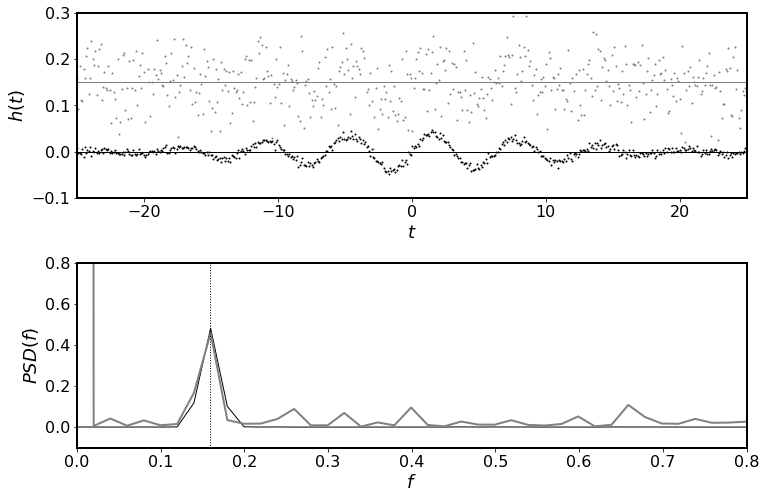

In [9]:
# https://www.astroml.org/book_figures/chapter10/fig_fft_example.html
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
#import numpy as np
#from matplotlib import pyplot as plt

from scipy.fftpack import fft
from scipy.stats import norm

from astroML.fourier import PSD_continuous

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
#if "setup_text_plots" not in globals():
#    from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Draw the data
np.random.seed(1)

tj = np.linspace(-25, 25, 512)
hj = np.sin(tj)
hj *= norm(0, 10).pdf(tj)

#------------------------------------------------------------
# plot the results
#fig = plt.figure(figsize=(5, 3.75))
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(hspace=0.35)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

offsets = (0, 0.15)
colors = ('black', 'gray')
linewidths = (1, 2)
errors = (0.005, 0.05)

for (offset, color, error, linewidth) in zip(offsets, colors,
                                             errors, linewidths):
    # compute the PSD
    err = np.random.normal(0, error, size=hj.shape)
    hj_N = hj + err + offset
    fk, PSD = PSD_continuous(tj, hj_N)

    # plot the data and PSD
    ax1.scatter(tj, hj_N, s=4, c=color, lw=0)
    ax1.plot(tj, 0 * tj + offset, '-', c=color, lw=1)
    ax2.plot(fk, PSD, '-', c=color, lw=linewidth)

# vertical line marking the expected peak location
ax2.plot([0.5 / np.pi, 0.5 / np.pi], [-0.1, 1], ':k', lw=1)

ax1.set_xlim(-25, 25)
ax1.set_ylim(-0.1, 0.3001)

ax1.set_xlabel('$t$')
ax1.set_ylabel('$h(t)$')

ax1.yaxis.set_major_locator(plt.MultipleLocator(0.1))

ax2.set_xlim(0, 0.8)
ax2.set_ylim(-0.101, 0.801)

ax2.set_xlabel('$f$')
ax2.set_ylabel('$PSD(f)$')

plt.show()

### Multi-dimensional FFT

A 2-dimensional FFT is
$$
H(n_1,n_2) \equiv \sum_{k_2=0}^{N_2-1}
                  \sum_{k_1=0}^{N_1-1}
		  e^{2\pi i \,k_2 n_2/N_2}
		  e^{2\pi i \,k_1 n_1/N_1}
		  h(k_1,k_2).
$$

N-dimensional FFTs can be computed by repeated applications of 1-d FFTs, with a fair amount of bookkeeping.

It is generally easiest to use a routine specifically written for multi-dimensional FFTs.

If you are starting with a real array, you should try to use a real-to-complex routine to save memory.

Pay careful attention to how the data are stored --- this may be different from one routine to another, and it is the
trickiest thing to figure out.

### Calculating gravitational accelerations by FFT

Computing gravitational potentials is an interesting special case of convolution.

Suppose we want to compute the gravitational forces in a system of $N$ bodies, where $N$ might be very large (for example $10^6-10^9$) to represent a galaxy or a large cosmological volume.

A naive calculation of
$$
\vec a_j = \sum_{i=1}^N - {Gm_i \vec r_{ij} \over r_{ij}^3}
$$
is $O(N^2)$ for $N$ particles.

Impossible to do large $N$.  Need more efficient method.

One approach:

$$\eqalign{
\nabla^2\phi(\vec r) &= 4\pi G\rho(\vec r) \cr
\phi(\vec r) &= \int \tphi (\vec k) e^{-2\pi i \vec k \cdot \vec r} d^3k,
}
$$
where
$$
\tphi(\vec k) = \int \phi (\vec r) e^{2\pi i \vec k \cdot \vec r} d^3r 
$$ 
is the Fourier transform of $\phi$.

$$\eqalign{
\vec\nabla\phi &= -2\pi i\vec k\int\tphi(\vec k)e^{-2\pi i\vec k\cdot\vec r}d^3k \cr
\nabla^2\phi &= -4\pi^2 k^2 \int\tphi(\vec k)e^{-2\pi i\vec k\cdot\vec r}d^3k.
}
$$

Hence $4\pi G\rho(r) = \nabla^2\phi(r)$ implies
$$
4\pi G\ \int \trho (\vec k) e^{-2\pi i \vec k\cdot\vec r} d^3k = 
-4\pi^2 k^2 \int\tphi(\vec k)e^{-2\pi i\vec k\cdot\vec r}d^3k,
$$
implying
$$
\tphi(\vec k) = -{G \over \pi k^2}\trho(\vec k).
$$

This can be a very efficient means of computing the gravitational potential because of numerically efficient Fourier transform routines.

#### Basic scheme:

Compute $\rho(x,y,z)$ on grid from particle distribution by interpolation.

Compute $\trho(k_x,k_y,k_z)$ by FFT, then $\tphi$ from above equation.

Inverse FFT to get $\phi(x,y,z)$.  

Numerically differentiate $\phi(x,y,z)$ to get accelerations.

There are various subtleties about how to do the differentiation, and about the best choice of "Green's function"
(which may not be simply $1/k^2$).

Forces are automatically softened (relative to $1/r^2$) on the scale of grid cell.

If this is adequate force resolution, then the FFT method is very efficient.

The FFT method naturally imposes a periodic boundary condition, which is sometimes desirable (e.g., a cosmological volume) and sometimes not (e.g., a galaxy merger).

### FFTW

The best library of routines for high-performance FFTs is probably `FFTW`, "The Fastest Fourier Transform in the West," freely available from www.fftw.org.

The FFTW routines analyze your machine to decide what algorithm will actually run fastest on your available hardware.

Equally important, the library includes multi-dimensional FFTs, real-to-complex FFTs, and works with any dimension of
array, not just powers of 2.  

You will probably get the best performance if you use array sizes that are multiples of powers of 2, 3, and 5.

There is a `pyFFTW` package that is a pythonic wrapper around FFWT such that they are called like the `numpy.fft` routines.

If you're working in python and want higher performance code, it is worthwhile to use `pyFFTW`. If not, the numpy or scipy implementations are straightforward and should already be available by default. In some tests I ran, I found the scipy implementation is actually almost as good as pyFFTW. Note also that performance differences are not too meaningful for small arrays. 

If you're working in C or Fortran, you may want to simply use the FFTW routines.

### Example usage and performance comparison of np.fft, sp.fftp, and FFTW

For a short intro and tutorial on pyFFTW see: https://hgomersall.github.io/pyFFTW/

In [10]:
# Create a random array for testing
np.random.seed(1216)
N = 2**18
vec = np.random.random(size=(N)).astype('float32')

%timeit -r 5 -n 256 np.fft.rfftn(vec)

3.29 ms ± 23.4 µs per loop (mean ± std. dev. of 5 runs, 256 loops each)


In [11]:
# Compute the FFT with scipy 
%timeit -r 5 -n 256 sp.fft.rfftn(vec)

2.09 ms ± 31.3 µs per loop (mean ± std. dev. of 5 runs, 256 loops each)


In [12]:
pyvec = pyfftw.byte_align(vec, dtype=vec.dtype)
%timeit  -r 5 -n 256 pyfftw.interfaces.numpy_fft.rfft(pyvec)

1.48 ms ± 93 µs per loop (mean ± std. dev. of 5 runs, 256 loops each)


### Examples of the frequency power spectrum for different sampling rates

In [13]:
def gettwocos(f1, f2, t1=-0.3, t2=0.3, dt=0.0015): 
    '''
    create a signal that is the sum of two cosines
    '''
    t = np.arange(t1, t2, dt)
    s = np.cos(2*f1*np.pi*t) + np.cos(2*np.pi*f2*t) # signal sampling
    return t, s

def getfreqs(t, s):
    '''
    return the power spectrum density as a function of frequency
    '''
    ps = np.abs(np.fft.fft(s))**2  # PSD
    dt = t[1]-t[0]
    freqs = np.fft.rfftfreq(s.size, dt)  # (real) FT sample frequencies
    indxs = np.argsort(freqs)
    return freqs[indxs], ps[indxs]

Text(0, 0.5, '$signal^2$/Hz')

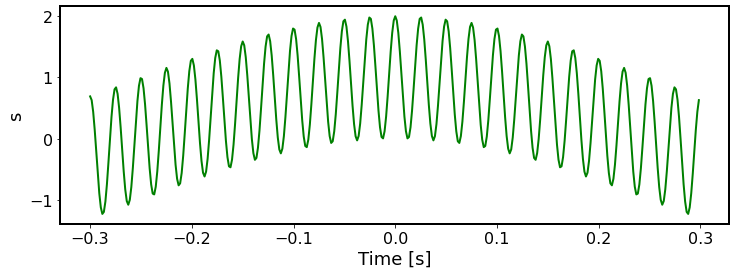

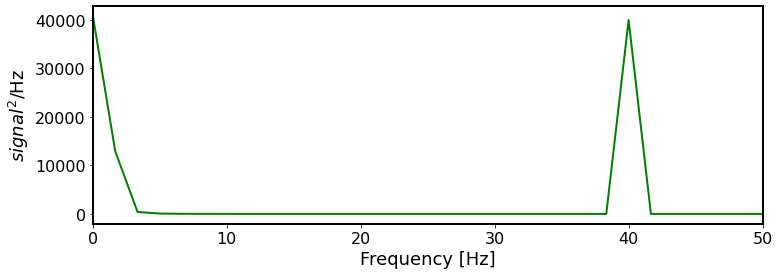

In [14]:
freq1 = 40 # Hz
freq2 = 1 # Hz
dt = 0.0015
tmin = -0.3
tmax = 0.3
t, s = gettwocos(freq1, freq2, t1=tmin, t2=tmax, dt=dt)

plt.figure(figsize=(12, 4))
plt.plot(t, s, 'g')
plt.xlabel("Time [s]")
plt.ylabel("s")

frq, amp = getfreqs(t, s)

plt.figure(figsize=(12, 4))
plt.plot(frq, amp, 'g')
plt.xlim(0, 50)
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$signal^2$/Hz")

The upper panel shows the sum of two cosines, one with a frequency of 40 Hz, the other with a frequency of 1 Hz. The signal is sampled for only for 0.6s, which is insufficient to sample the 1 Hz signal. The lower panel shows the real component of the power spectrum with a peak at 40 Hz and a broader peak centered on 0 Hz. The width of this peak around 0 Hz is broad because the frequency bin size is 1/(tmax-tmin) = 1/0.6 = 1.67 Hz, which is too coarse to resolve the 1 Hz signal. If the time series were at least 2 seconds, then the frequency bin size would be 0.5 Hz and sufficient to resolve the signal. This is shown in the next plot

Text(0, 0.5, '$signal^2$/Hz')

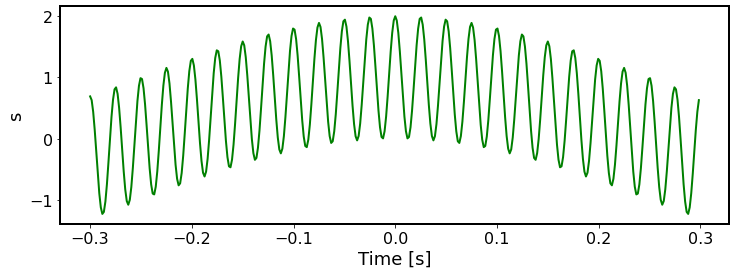

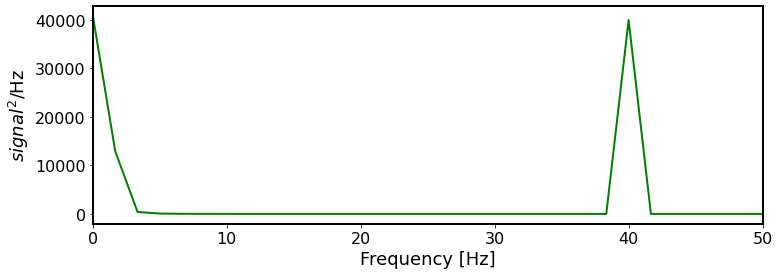

In [15]:
freq1 = 40 # Hz
freq2 = 1 # Hz
tmin = -0.3
tmax = 0.3
t, s = gettwocos(freq1, freq2, t1=tmin, t2=tmax, dt=dt)

plt.figure(figsize=(12, 4))
plt.plot(t, s, 'g')
plt.xlabel("Time [s]")
plt.ylabel("s")

frq, amp = getfreqs(t, s)

plt.figure(figsize=(12, 4))
plt.plot(frq, amp, 'g')
plt.xlim(0, 50)
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$signal^2$/Hz")

In [16]:
# Note the full frequency range extends to 

print("Note the full frequence range extends to ", frq.max())

# This is equivalent to half the temporal sampling:

print("This is equivalent to half the temporal sampling, 1/(2*dt) = ", 1/(2*dt) )

print("Now consider if the higher frequency signal were sampled at exactly the Nyquist frequency")

Note the full frequence range extends to  333.33333333333303
This is equivalent to half the temporal sampling, 1/(2*dt) =  333.3333333333333
Now consider if the higher frequency signal were sampled at exactly the Nyquist frequency


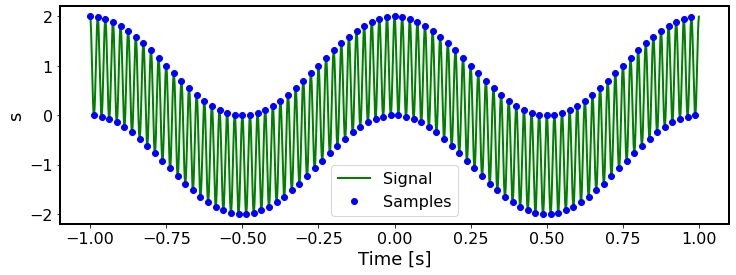

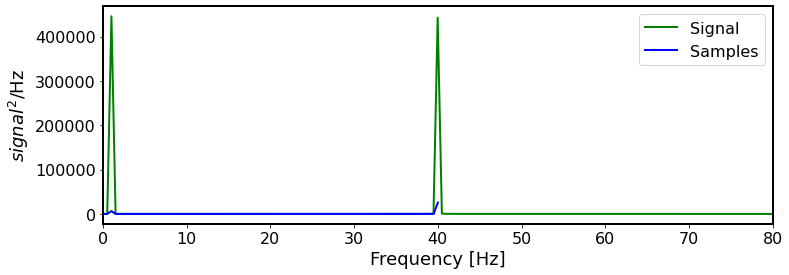

In [17]:
freq1 = 40 # Hz
freq2 = 1 # Hz
tmin = -1
tmax = 1
t, s = gettwocos(freq1, freq2, t1=tmin, t2=tmax, dt=0.0015)

t2, s2 = gettwocos(freq1, freq2, t1=tmin, t2=tmax, dt=1./(2*freq1))

plt.figure(figsize=(12, 4))
plt.plot(t, s, 'g', label="Signal")
plt.plot(t2, s2, 'bo', label="Samples")
plt.xlabel("Time [s]")
plt.ylabel("s")
plt.legend()

frq, amp = getfreqs(t, s)
frq2, amp2 = getfreqs(t2, s2)

plt.figure(figsize=(12, 4))
plt.plot(frq, amp, 'g', label="Signal")
plt.plot(frq2, amp2, 'b', label="Samples")
plt.xlim(0, 80)
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$signal^2$/Hz")
plt.legend()

The panels above show the samples barely register the signal at the Nyquist frequency. If the sampling were out of phase with the signal, it would not see it:

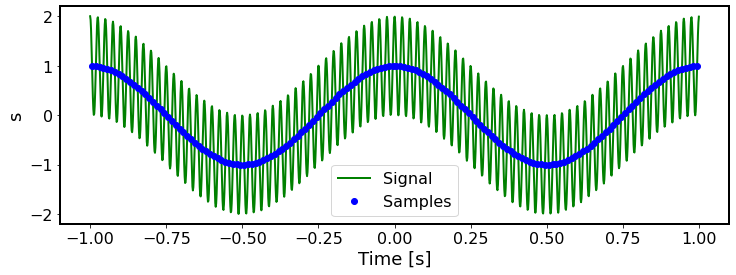

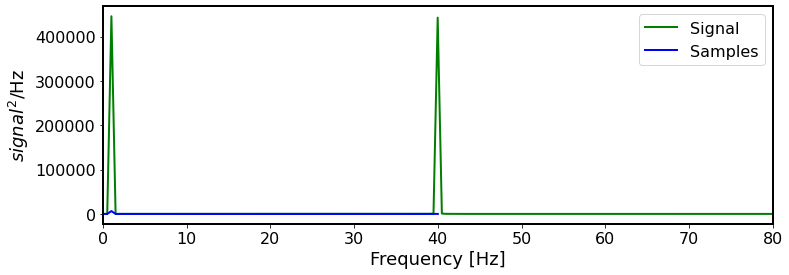

In [18]:
freq1 = 40 # Hz
freq2 = 1 # Hz
tmin = -1
tmax = 1
t, s = gettwocos(freq1, freq2, t1=tmin, t2=tmax, dt=dt)

dt2 = 1./(2*freq1)
t2 = np.arange(tmin, tmax, dt2) + 1./(4*freq1)
s2 = np.cos(2*freq1*np.pi*t2) + np.cos(2*np.pi*freq2*t2) # signal sampling

plt.figure(figsize=(12, 4))
plt.plot(t, s, 'g', label="Signal")
plt.plot(t2, s2, 'bo', label="Samples")
plt.xlabel("Time [s]")
plt.ylabel("s")
plt.legend()

frq, amp = getfreqs(t, s)
frq2, amp2 = getfreqs(t2, s2)

plt.figure(figsize=(12, 4))
plt.plot(frq, amp, 'g', label="Signal")
plt.plot(frq2, amp2, 'b', label="Samples")
plt.xlim(0, 80)
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"$signal^2$/Hz")
plt.legend()

Note that the above panel shows that only the signal at 1 Hz.